<a href="https://colab.research.google.com/github/Ginaris24/Serangan-Jantung-Di-Indonesia/blob/main/Source_Code_UAS_ADV_BIGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170501 entries, 0 to 170500
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         170501 non-null  int64  
 1   State                      170501 non-null  object 
 2   Age                        170501 non-null  int64  
 3   HeartAttack                170501 non-null  object 
 4   Gender                     170501 non-null  object 
 5   Cholesterol                170501 non-null  int64  
 6   SmokingHabits              170501 non-null  object 
 7   PhysicalActivity           170501 non-null  object 
 8   BMI                        170501 non-null  float64
 9   Hypertension               170501 non-null  object 
 10  Diabetes                   170501 non-null  object 
 11  AlcoholConsumption         113873 non-null  object 
 12  DietType                   170501 non-null  object 
 13  OccupationType             17

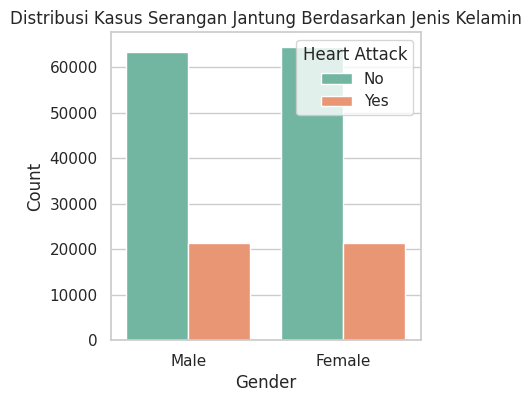

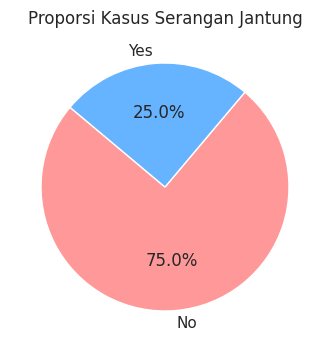

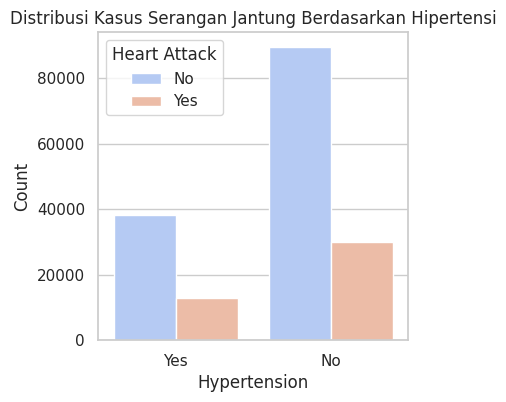

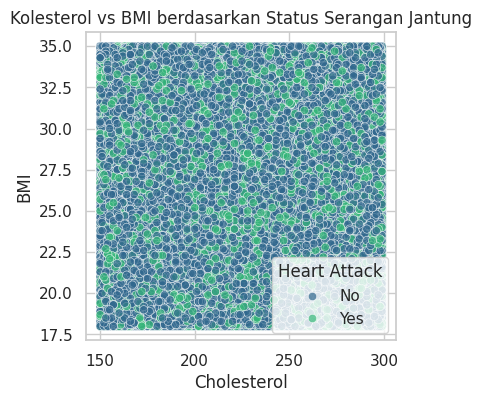

In [8]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("HeartAttackClassification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

# Load dataset
file_path = 'heart_attack_indonesia.csv'
data = pd.read_csv(file_path)

# Cek Tipe Data
data.info()

# Rename columns to be more descriptive
data.rename(columns={
    'HeartAttack': 'Heart_Attack',
    'SmokingHabits': 'Smoking_Habits',
    'PhysicalActivity': 'Physical_Activity',
    'FamilyHistoryHeartDisease': 'Family_History_Heart_Disease',
    'HealthcareAccess': 'Healthcare_Access',
    'UrbanOrRural': 'Urban_Or_Rural',
    'AirQualityIndex': 'Air_Quality_Index',
    'PollutionLevel': 'Pollution_Level',
    'EmploymentStatus': 'Employment_Status'
}, inplace=True)

# Convert to Spark DataFrame
data_spark = spark.createDataFrame(data)

# Check for null values
null_values = data.isnull().sum()
print("Null values per column:")
print(null_values)

# Encode categorical columns using StringIndexer
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_Index").fit(data_spark)
    for col in ["Gender", "Smoking_Habits", "Hypertension", "Family_History_Heart_Disease", "Heart_Attack"]
]
for indexer in indexers:
    data_spark = indexer.transform(data_spark)

# Generate summary statistics for numerical columns
summary_stats = data.describe()
print("\nSummary statistics:")
print(summary_stats)

# Assemble features into a single vector
feature_cols = [
    "Age", "Cholesterol", "BMI", "SleepHours", "Air_Quality_Index",
    "Gender_Index", "Smoking_Habits_Index", "Hypertension_Index", "Family_History_Heart_Disease_Index"
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_spark = assembler.transform(data_spark)

# Compute correlation matrix for numerical features
numeric_columns = data.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

# Visualizations
sns.set(style="whitegrid")

# 1. Bar chart: Distribution of Heart Attack cases by Gender
plt.figure(figsize=(4, 4))
sns.countplot(data=data, x="Gender", hue="Heart_Attack", palette="Set2")
plt.title("Distribusi Kasus Serangan Jantung Berdasarkan Jenis Kelamin")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Heart Attack")
plt.show()

# 2. Pie chart: Proportion of Heart Attack cases
heart_attack_proportion = data["Heart_Attack"].value_counts()
plt.figure(figsize=(4, 6))
heart_attack_proportion.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=["#ff9999", "#66b3ff"])
plt.title("Proporsi Kasus Serangan Jantung")
plt.ylabel("")
plt.show()

# 3. Bar chart: Distribution of Heart Attack cases by Hypertension
plt.figure(figsize=(4, 4))
sns.countplot(data=data, x="Hypertension", hue="Heart_Attack", palette="coolwarm")
plt.title("Distribusi Kasus Serangan Jantung Berdasarkan Hipertensi")
plt.xlabel("Hypertension")
plt.ylabel("Count")
plt.legend(title="Heart Attack")
plt.show()

# 4. Scatter plot: Cholesterol vs BMI with Heart Attack status
plt.figure(figsize=(4, 4))
sns.scatterplot(data=data, x="Cholesterol", y="BMI", hue="Heart_Attack", palette="viridis", alpha=0.7)
plt.title("Kolesterol vs BMI berdasarkan Status Serangan Jantung")
plt.xlabel("Cholesterol")
plt.ylabel("BMI")
plt.legend(title="Heart Attack")
plt.show()


#2.

In [6]:
# Split data into training and test sets
train_data, test_data = data_spark.randomSplit([0.8, 0.2], seed=42)

# Define models
models = {
    "RandomForest": RandomForestClassifier(labelCol="Heart_Attack_Index", featuresCol="features"),
    "GBTClassifier": GBTClassifier(labelCol="Heart_Attack_Index", featuresCol="features"),
    "LogisticRegression": LogisticRegression(labelCol="Heart_Attack_Index", featuresCol="features"),
    "DecisionTree": DecisionTreeClassifier(labelCol="Heart_Attack_Index", featuresCol="features")
}

# Evaluation metrics
evaluator_auc = BinaryClassificationEvaluator(labelCol="Heart_Attack_Index", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Heart_Attack_Index")

# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    trained_model = model.fit(train_data)

    # Make predictions
    predictions = trained_model.transform(test_data)

    # Evaluate metrics
    auc = evaluator_auc.evaluate(predictions)
    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
    precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})

    # Store results
    results[model_name] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Display results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Hyperparameter tuning for top models
top_models = ["RandomForest", "GBTClassifier"]
hyperparameter_results = {}

for model_name in top_models:
    if model_name == "RandomForest":
        model = RandomForestClassifier(labelCol="Heart_Attack_Index", featuresCol="features")
        param_grid = ParamGridBuilder() \
            .addGrid(model.numTrees, [10, 20]) \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()
    elif model_name == "GBTClassifier":
        model = GBTClassifier(labelCol="Heart_Attack_Index", featuresCol="features")
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxIter, [10, 20]) \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

    # Use TrainValidationSplit for tuning
    train_val_split = TrainValidationSplit(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator_auc,
        trainRatio=0.8
    )

    # Train and select the best model
    cv_model = train_val_split.fit(train_data)
    best_model = cv_model.bestModel

    # Evaluate the best model
    predictions = best_model.transform(test_data)
    auc = evaluator_auc.evaluate(predictions)
    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
    precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})

    # Store hyperparameter tuning results
    hyperparameter_results[model_name] = {
        "AUC": auc,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Best Params": best_model.extractParamMap()
    }

# Display hyperparameter tuning results
for model_name, metrics in hyperparameter_results.items():
    print(f"\nHyperparameter Tuning - Model: {model_name}")
    for metric_name, value in metrics.items():
        if metric_name != "Best Params":
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: {value}")



Model: RandomForest
AUC: 0.5027
Accuracy: 0.7495
F1 Score: 0.6422
Precision: 0.5618
Recall: 0.7495

Model: GBTClassifier
AUC: 0.4962
Accuracy: 0.7495
F1 Score: 0.6422
Precision: 0.5618
Recall: 0.7495

Model: LogisticRegression
AUC: 0.5002
Accuracy: 0.7495
F1 Score: 0.6422
Precision: 0.5618
Recall: 0.7495

Model: DecisionTree
AUC: 0.5000
Accuracy: 0.7495
F1 Score: 0.6422
Precision: 0.5618
Recall: 0.7495

Hyperparameter Tuning - Model: RandomForest
AUC: 0.5026
Accuracy: 0.7495
F1 Score: 0.6422
Precision: 0.5618
Recall: 0.7495
Best Params: {Param(parent='RandomForestClassifier_c2a4d2a406cf', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_c2a4d2a406cf', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be 